In [24]:
%matplotlib inline
import warnings

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

from functions.functions import get_region_coords, colored_line, region_contours
from functions.latex import set_size

from matplotlib.collections import LineCollection
from global_land_mask import globe


datadir = "../data/"
figdir = "../figures/"

In [25]:
mdt = "dtu"
hydrography = "woa"

In [26]:
ds = xr.merge([xr.open_dataset(datadir + f"velocities_{mdt}_{hydrography}_ease.nc"),
               xr.open_dataset(datadir + "bathymetry_with_gradients_filter50_ease.nc")
              ]
             )
ds

<xarray.Dataset> Size: 7MB
Dimensions:  (y: 264, x: 264)
Coordinates:
    lat      (y, x) float32 279kB 47.33 47.5 47.67 47.84 ... 47.67 47.5 47.33
    lon      (y, x) float32 279kB -45.0 -44.78 -44.56 ... 135.4 135.2 135.0
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    mdt      (y, x) float64 558kB ...
    us       (y, x) float64 558kB ...
    vs       (y, x) float64 558kB ...
    ut       (y, x) float64 558kB ...
    vt       (y, x) float64 558kB ...
    ub       (y, x) float64 558kB ...
    vb       (y, x) float64 558kB ...
    depth    (y, x) float64 558kB ...
    dhdx     (y, x) float64 558kB ...
    dhdy     (y, x) float64 558kB ...
    slope    (y, x) float64 558kB ...
Attributes:
    long_name:     mean ocean dynamic topography
    units:         m
    actual_range:  [-2.205  2.457]

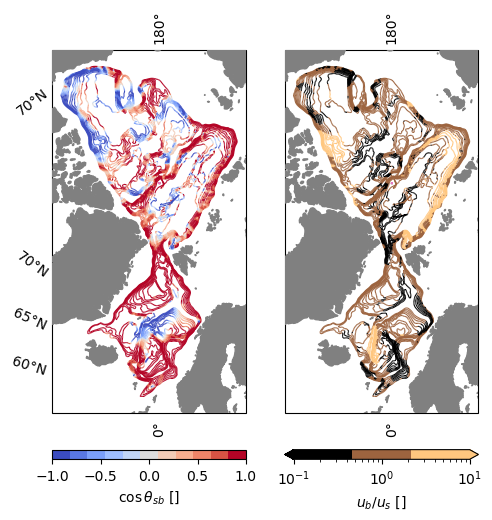

In [27]:
fig, ax = plt.subplots(1, 2,
                        figsize=set_size(width="AGU", subplots=(2, 1)),
                        subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                        )


cmap_0 = plt.get_cmap('coolwarm', 11)
cmap_1 = plt.get_cmap('copper', 3)
norm_0 = mcolors.Normalize(vmin=-1, vmax=1)
norm_1 = mcolors.LogNorm(vmin=1e-1, vmax=1e1)


ds_copy = ds.copy(deep=True)
# Create a condition mask
mask_copy = ds_copy.lon < 0
ds_copy = ds.assign_coords(lon=xr.where(mask_copy, ds.lon+360, ds.lon))

for region_name in region_contours:
    region = get_region_coords(region_name, xy=True)
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y, method="linear")
        ds_copy_interp = ds_copy.interp(x=contour.x, y=contour.y, method="linear")

        ds_interp = ds_interp.assign_coords(lon=xr.where(np.abs(ds_interp.lon) < 1, ds_interp.lon, ds_copy_interp.lon))
        speed_b = np.sqrt(ds_interp["ub"]**2 + ds_interp["vb"]**2)
        speed_s = np.sqrt(ds_interp["us"]**2 + ds_interp["vs"]**2)
        ds_interp["eb"] = (ds_interp["us"]*ds_interp["ub"] + ds_interp["vs"]*ds_interp["vb"])/(speed_b*speed_s)
        
        ax[0].plot(ds_interp.lon, ds_interp.lat)
        c_0 = colored_line(ds_interp.lon.values, ds_interp.lat.values, ds_interp.eb,
                           ax=ax[0],
                           cmap=cmap_0,
                           linewidth=0.8,
                           norm=norm_0,
                           zorder=10
                           )
        c_0.set_rasterized(True)
        ax[1].plot(ds_interp.lon, ds_interp.lat)
        c_1 = colored_line(ds_interp.lon.values, ds_interp.lat.values, speed_b/speed_s,
                           ax=ax[1],
                           cmap=cmap_1,
                           linewidth=0.8,
                           norm=norm_1,
                           zorder=10
                           )
        c_1.set_rasterized(True)

ax[0].set_aspect(1)
ax[0].add_feature(cfeature.LAND, color="grey", zorder=100)
gl0 = ax[0].gridlines(draw_labels=True, y_inline=False)
gl0.xlines = False
gl0.ylines = False
gl0.right_labels = False

ax[1].set_aspect(1)
ax[1].add_feature(cfeature.LAND, color="grey", zorder=100)
gl1 = ax[1].gridlines(draw_labels=True,
                      y_inline=False
                      )
gl1.xlines = False
gl1.ylines = False
gl1.right_labels = False
gl1.left_labels = False
fig.subplots_adjust(wspace=0.2)

fig.colorbar(c_0,
             label=r"$\cos{\theta_{sb}}$ []",
             location="bottom",
             shrink=1,
             pad=0.07
             )

fig.colorbar(c_1,
             label=r"$u_b$/$u_s$ []",
             location="bottom",
             shrink=1,
             pad=0.07,
             extend="both"
            )

fig.savefig(figdir + f"eb_alongcontour_latlon_{mdt}_{hydrography}_lines.pdf", dpi=300, bbox_inches="tight")